In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, Attention, AdditiveAttention
from tensorflow.keras.models import Model
import numpy as np
import os
from datetime import datetime # For checkpoint naming
import json
import pickle

In [56]:
from preprocessing import (
    filter_and_count_sentences,
    remove_attributes_from_filtered_sentences,
    load_cleaned_pairs,
    tokenize,
    build_vocab,
    sentences_to_indices,
    preprocess_data,
)

In [3]:
INPUT_FILE = "dataset/raw/eng_fra.txt" 
MAX_SENTENCE_WORDS = 20

In [4]:
filtered_raw_sentences, total_read, exceeding_pairs, eng_exceeding, fra_exceeding = \
    filter_and_count_sentences(INPUT_FILE, max_words=MAX_SENTENCE_WORDS)

print(f"Total sentences read from file: {total_read}")
print(f"Sentence pairs exceeding {MAX_SENTENCE_WORDS} words (either English or French): {exceeding_pairs}")
print(f"English sentences individually exceeding {MAX_SENTENCE_WORDS} words: {eng_exceeding}")
print(f"French sentences individually exceeding {MAX_SENTENCE_WORDS} words: {fra_exceeding}")
print(f"Number of sentences kept after filtering: {len(filtered_raw_sentences)}")

Total sentences read from file: 237838
Sentence pairs exceeding 20 words (either English or French): 430
English sentences individually exceeding 20 words: 170
French sentences individually exceeding 20 words: 394
Number of sentences kept after filtering: 237408


In [5]:
clean_filtered_sentences = remove_attributes_from_filtered_sentences(filtered_raw_sentences)
print(f"First 3 cleaned sentences (without attributes):\n{clean_filtered_sentences[:3]}")
print(f"Total cleaned sentences: {len(clean_filtered_sentences)}")

First 3 cleaned sentences (without attributes):
['Go.\tVa !', 'Go.\tMarche.', 'Go.\tEn route !']
Total cleaned sentences: 237408


In [6]:
sentence_pairs = load_cleaned_pairs(clean_filtered_sentences)
print(f"First 3 sentence pairs (list of lists):\n{sentence_pairs[:3]}")
print(f"Total sentence pairs: {len(sentence_pairs)}")

First 3 sentence pairs (list of lists):
[['Go.', 'Va !'], ['Go.', 'Marche.'], ['Go.', 'En route !']]
Total sentence pairs: 237408


In [7]:
eng_sents_for_vocab = [pair[0] for pair in sentence_pairs]
fra_sents_for_vocab = [pair[1] for pair in sentence_pairs]
tokenized_eng_for_vocab = tokenize(eng_sents_for_vocab)
tokenized_fra_for_vocab = tokenize(fra_sents_for_vocab)

print(f"First 3 tokenized English sentences:\n{tokenized_eng_for_vocab[:3]}")
print(f"First 3 tokenized French sentences:\n{tokenized_fra_for_vocab[:3]}")

First 3 tokenized English sentences:
[['go.'], ['go.'], ['go.']]
First 3 tokenized French sentences:
[['va', '!'], ['marche.'], ['en', 'route', '!']]


In [8]:
eng_vocab, eng_inv_vocab = build_vocab(tokenized_eng_for_vocab)
fra_vocab, fra_inv_vocab = build_vocab(tokenized_fra_for_vocab)

input_vocab_size = len(eng_vocab)
target_vocab_size = len(fra_vocab)


print(f"English Vocabulary Size: {input_vocab_size}")
print(f"French Vocabulary Size: {target_vocab_size}")
print(f"Sample English Vocab (first 10 items): {list(eng_vocab.items())[:10]}")
print(f"Sample French Vocab (first 10 items): {list(fra_vocab.items())[:10]}")

English Vocabulary Size: 30691
French Vocabulary Size: 49061
Sample English Vocab (first 10 items): [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('go.', 4), ('hi.', 5), ('run!', 6), ('run.', 7), ('who?', 8), ('wow!', 9)]
Sample French Vocab (first 10 items): [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('va', 4), ('!', 5), ('marche.', 6), ('en', 7), ('route', 8), ('bouge', 9)]


In [10]:
Tx = 22
Ty = 20

In [12]:
# Preprocess Data for Model Input
encoder_input_data, decoder_input_data, decoder_target_data = preprocess_data(
    sentence_pairs, eng_vocab, fra_vocab, Tx=22, Ty=20
)

In [13]:
print(f"Shape of Encoder Input Data: {encoder_input_data.shape}")     # (num_samples, Tx)
print(f"Shape of Decoder Input Data: {decoder_input_data.shape}")     # (num_samples, Ty - 1)
print(f"Shape of Decoder Target Data: {decoder_target_data.shape}")   # (num_samples, Ty)

Shape of Encoder Input Data: (237408, 22)
Shape of Decoder Input Data: (237408, 20)
Shape of Decoder Target Data: (237408, 20)


### Save Data

In [6]:
output_dir = "dataset/processed"
# os.makedirs(output_dir, exist_ok=True)

In [5]:
# file paths
encoder_path = os.path.join(output_dir, "encoder_input_data.npy")
decoder_input_path = os.path.join(output_dir, "decoder_input_data.npy")
decoder_target_path = os.path.join(output_dir, "decoder_target_data.npy")
eng_vocab_path = os.path.join(output_dir, "eng_vocab.npy")
fra_vocab_path = os.path.join(output_dir, "fra_vocab.npy")

In [18]:
# Save the NumPy arrays
np.save(encoder_path, encoder_input_data)
np.save(decoder_input_path, decoder_input_data)
np.save(decoder_target_path, decoder_target_data)


with open(eng_vocab_path.replace('.npy', '.json'), 'w', encoding='utf-8') as f:
    json.dump(eng_vocab, f, ensure_ascii=False, indent=4)
with open(fra_vocab_path.replace('.npy', '.json'), 'w', encoding='utf-8') as f:
    json.dump(fra_vocab, f, ensure_ascii=False, indent=4)


print(f"\nPreprocessed data saved to '{output_dir}':")
print(f"- {os.path.basename(encoder_path)}")
print(f"- {os.path.basename(decoder_input_path)}")
print(f"- {os.path.basename(decoder_target_path)}")
print(f"- {os.path.basename(eng_vocab_path.replace('.npy', '.json'))}")
print(f"- {os.path.basename(fra_vocab_path.replace('.npy', '.json'))}")


Preprocessed data saved to 'dataset/processed':
- encoder_input_data.npy
- decoder_input_data.npy
- decoder_target_data.npy
- eng_vocab.json
- fra_vocab.json


### Loading Data

In [33]:
# file paths
output_dir = "dataset/processed"

encoder_path = os.path.join(output_dir, "encoder_input_data.npy")
decoder_input_path = os.path.join(output_dir, "decoder_input_data.npy")
decoder_target_path = os.path.join(output_dir, "decoder_target_data.npy")
eng_vocab_path = os.path.join(output_dir, "eng_vocab.npy")
fra_vocab_path = os.path.join(output_dir, "fra_vocab.npy")

encoder_input_data_loaded = np.load(encoder_path)
decoder_input_data_loaded = np.load(decoder_input_path)
decoder_target_data_loaded = np.load(decoder_target_path)
with open(eng_vocab_path.replace('.npy', '.json'), 'r', encoding='utf-8') as f:
    eng_vocab_loaded = json.load(f)
with open(fra_vocab_path.replace('.npy', '.json'), 'r', encoding='utf-8') as f:
    fra_vocab_loaded = json.load(f)

In [34]:
print(f"Shape of Encoder Input Data: {encoder_input_data_loaded.shape}")     # (num_samples, Tx)
print(f"Shape of Decoder Input Data: {decoder_input_data_loaded.shape}")     # (num_samples, Ty - 1)
print(f"Shape of Decoder Target Data: {decoder_target_data_loaded.shape}")   # (num_samples, Ty)

Shape of Encoder Input Data: (237408, 22)
Shape of Decoder Input Data: (237408, 20)
Shape of Decoder Target Data: (237408, 20)


In [35]:
Tx = 22
Ty = 20

In [36]:
encoder_input_data = encoder_input_data_loaded
decoder_input_data = decoder_input_data_loaded
decoder_target_data = decoder_target_data_loaded
eng_vocab = eng_vocab_loaded
fra_vocab = fra_vocab_loaded
input_vocab_size = len(eng_vocab)
target_vocab_size = len(fra_vocab)

In [7]:
def create_nmt_model(Tx, Ty, input_vocab_size, target_vocab_size, embedding_dim=128, lstm_units=128):
    """
    Builds a Sequence-to-Sequence NMT model with Bidirectional LSTM encoder,
    Additive Attention, and Unidirectional LSTM decoder. Returns models for
    training and inference.

    Args:
        Tx (int): Max input sequence length (encoder).
        Ty (int): Max target sequence length (decoder input and target length, including EOS).
                  This 'Ty' value should be consistent with the `maxlen` used for
                  padding `decoder_input_padded` and `decoder_target_padded` in `preprocess_data`.
        input_vocab_size (int): Input vocabulary size.
        target_vocab_size (int): Target vocabulary size.
        embedding_dim (int): Dimensionality of the word embeddings.
        lstm_units (int): LSTM units per direction in encoder.

    Returns:
        tf.keras.Model: The compiled training model.
        tf.keras.Model: The encoder inference model.
        tf.keras.Model: The decoder inference model.
        tf.keras.layers.Dense: The final output dense layer (shared for reuse).
        tf.keras.layers.AdditiveAttention: The attention layer (shared for reuse).
        tf.keras.layers.LSTM: The decoder LSTM layer (shared for reuse).
        tf.keras.layers.Embedding: The decoder embedding layer (shared for reuse).
    """

    # --- FIX: Ensure embedding_dim matches lstm_units for attention compatibility ---
    # You can either pass embedding_dim=lstm_units when calling this function
    # OR set it explicitly here. Let's make it consistent by default.
    embedding_dim_for_attention = lstm_units # <--- KEY CHANGE HERE

    # --- Shared Layers (to reuse weights between training and inference models) ---
    # Use embedding_dim_for_attention for both embedding layers
    encoder_embedding_layer = Embedding(input_vocab_size, embedding_dim_for_attention, mask_zero=True, name="encoder_embedding")
    encoder_bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.3), name="bi_encoder_lstm")
    encoder_outputs_projection_layer = Dense(lstm_units, activation="tanh", name="encoder_outputs_projection")

    decoder_embedding_layer = Embedding(target_vocab_size, embedding_dim_for_attention, mask_zero=True, name="decoder_embedding") # <--- KEY CHANGE HERE
    attention_layer = AdditiveAttention(name="attention_layer")
    decoder_lstm = LSTM(lstm_units * 2, return_sequences=True, return_state=True, dropout=0.3, name="decoder_lstm")
    output_dense_layer = Dense(target_vocab_size, activation='softmax', name="output_dense")


    # --- 1. Training Model Architecture ---

    # Encoder Input & Processing
    encoder_inputs = Input(shape=(Tx,), name="encoder_inputs")
    enc_embedding_output = encoder_embedding_layer(encoder_inputs)
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(enc_embedding_output)
    encoder_outputs_projected = encoder_outputs_projection_layer(encoder_outputs)

    # Combine forward and backward states for decoder initialization
    state_h = Concatenate(name="decoder_initial_h")([forward_h, backward_h])
    state_c = Concatenate(name="decoder_initial_c")([forward_c, backward_c])

    # Decoder Input & Processing (for training with Teacher Forcing)
    decoder_inputs = Input(shape=(Ty,), name="decoder_inputs") # Input shape consistent with Ty
    dec_embedding_output = decoder_embedding_layer(decoder_inputs)

    # Attention Calculation for Training
    context_vector = attention_layer([dec_embedding_output, encoder_outputs_projected])
    decoder_combined_input = Concatenate(axis=-1, name="decoder_combined_input")([dec_embedding_output, context_vector])

    # Decoder LSTM for Training
    decoder_outputs, _, _ = decoder_lstm(decoder_combined_input, initial_state=[state_h, state_c])
    decoder_predictions = output_dense_layer(decoder_outputs)

    # Create the Training Model
    training_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_predictions, name="nmt_training_model")


    # --- 2. Encoder Inference Model ---
    encoder_inference_model = Model(inputs=encoder_inputs,
                                    outputs=[encoder_outputs_projected, state_h, state_c],
                                    name="encoder_inference_model")

    # --- 3. Decoder Inference Model ---
    decoder_input_single_token = Input(shape=(1,), name="decoder_input_single_token")
    encoder_states_input = Input(shape=(Tx, lstm_units,), name="encoder_states_input")
    decoder_state_h_input = Input(shape=(lstm_units * 2,), name="decoder_h_input")
    decoder_state_c_input = Input(shape=(lstm_units * 2,), name="decoder_c_input")

    # Embed the single input token
    dec_single_embedding_output = decoder_embedding_layer(decoder_input_single_token) # (batch_size, 1, embedding_dim_for_attention)

    # Attention Calculation for Inference
    inference_context_vector = attention_layer([dec_single_embedding_output, encoder_states_input])
    inference_decoder_combined_input = Concatenate(axis=-1, name="decoder_combined_input_inference")([dec_single_embedding_output, inference_context_vector])

    # Decoder LSTM for Inference (one step)
    inference_decoder_outputs, h_state_output, c_state_output = decoder_lstm(
        inference_decoder_combined_input,
        initial_state=[decoder_state_h_input, decoder_state_c_input]
    )

    # Final Output Layer for Inference
    inference_predictions = output_dense_layer(inference_decoder_outputs)

    # Create the Decoder Inference Model
    decoder_inference_model = Model(
        inputs=[decoder_input_single_token, encoder_states_input, decoder_state_h_input, decoder_state_c_input],
        outputs=[inference_predictions, h_state_output, c_state_output],
        name="decoder_inference_model"
    )

    # Return all components
    return training_model, encoder_inference_model, decoder_inference_model, \
           output_dense_layer, attention_layer, decoder_lstm, decoder_embedding_layer

In [8]:
training_model, encoder_inference_model, decoder_inference_model, \
           output_dense_layer, attention_layer, decoder_lstm, decoder_embedding_layer = \
create_nmt_model(Tx, Ty, input_vocab_size, target_vocab_size)

In [9]:
training_model.summary()

Model: "nmt_training_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 22)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 22, 128)      3928448     ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 bi_encoder_lstm (Bidirectional  [(None, 22, 256),   263168      ['encoder_embedding[0][0]']      
 )                               (None, 128),                                    

In [10]:
print("\n--- Compiling Model ---")
training_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)


--- Compiling Model ---


In [11]:
def prepare_dataset(encoder_input, decoder_input, decoder_target, batch_size=64, buffer_size=10000):
    dataset = tf.data.Dataset.from_tensor_slices(((encoder_input, decoder_input), decoder_target))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [13]:
num_total_samples = len(encoder_input_data)
num_total_samples

237408

In [14]:
# Constants
VALIDATION_SPLIT_RATIO = 0.03
TEST_SPLIT_RATIO = 0.03
num_total_samples = 237408

# Compute exact split sizes
num_val_samples = int(num_total_samples * VALIDATION_SPLIT_RATIO)  # 7122
num_test_samples = int(num_total_samples * TEST_SPLIT_RATIO)      # 7122
num_train_samples = num_total_samples - num_val_samples - num_test_samples  # 223164

print(f"\nTotal samples: {num_total_samples}")
print(f"Training samples: {num_train_samples}")
print(f"Validation samples: {num_val_samples}")
print(f"Test samples: {num_test_samples}")

# Split the NumPy arrays
train_encoder_input = encoder_input_data[:num_train_samples]
train_decoder_input = decoder_input_data[:num_train_samples]
train_decoder_target = decoder_target_data[:num_train_samples]

val_encoder_input = encoder_input_data[num_train_samples:num_train_samples + num_val_samples]
val_decoder_input = decoder_input_data[num_train_samples:num_train_samples + num_val_samples]
val_decoder_target = decoder_target_data[num_train_samples:num_train_samples + num_val_samples]

test_encoder_input = encoder_input_data[-num_test_samples:]
test_decoder_input = decoder_input_data[-num_test_samples:]
test_decoder_target = decoder_target_data[-num_test_samples:]

# Create tf.data.Dataset for training, validation, and test
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_dataset = prepare_dataset(train_encoder_input, train_decoder_input, train_decoder_target,
                                batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

val_dataset = prepare_dataset(val_encoder_input, val_decoder_input, val_decoder_target,
                              batch_size=BATCH_SIZE, buffer_size=1)

test_dataset = prepare_dataset(test_encoder_input, test_decoder_input, test_decoder_target,
                               batch_size=BATCH_SIZE, buffer_size=1)


Total samples: 237408
Training samples: 223164
Validation samples: 7122
Test samples: 7122


In [19]:
import shutil

checkpoint_dir = "checkpoints"

if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
    print(f"Deleted directory: {checkpoint_dir}")
else:
    print("Checkpoint directory does not exist.")


Checkpoint directory does not exist.


In [18]:
# To save at the end of every epoch, with a unique filename for each epoch:
checkpoint_path_per_epoch = "checkpoints/nmt_model_epoch_{epoch:02d}.keras"

checkpoint_cb_per_epoch = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_per_epoch,
    monitor='val_loss',
    save_best_only=False,  # Save every epoch
    save_weights_only=False,
    verbose=1 # To see when it saves
)

# To save only the BEST model based on val_loss:
checkpoint_path_best = "checkpoints/nmt_model_best.keras"

checkpoint_cb_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_best,
    monitor='val_loss',
    save_best_only=True,  # Only save if val_loss improves
    save_weights_only=False,
    verbose=1
)

In [20]:
print("\n--- Training Model ---")

history = training_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_cb_per_epoch, checkpoint_cb_best] 
)

print("\nTraining complete!")


--- Training Model ---
Epoch 1/10
3486/3487 [============================>.] - ETA: 0s - loss: 1.4557 - accuracy: 0.3882
Epoch 1: saving model to checkpoints/nmt_model_epoch_01.keras

Epoch 1: val_loss improved from inf to 2.45557, saving model to checkpoints/nmt_model_best.keras
3487/3487 [==============================] - 189s 51ms/step - loss: 1.4558 - accuracy: 0.3882 - val_loss: 2.4556 - val_accuracy: 0.3644
Epoch 2/10
3486/3487 [============================>.] - ETA: 0s - loss: 0.8922 - accuracy: 0.5525
Epoch 2: saving model to checkpoints/nmt_model_epoch_02.keras

Epoch 2: val_loss improved from 2.45557 to 2.12381, saving model to checkpoints/nmt_model_best.keras
3487/3487 [==============================] - 177s 51ms/step - loss: 0.8923 - accuracy: 0.5525 - val_loss: 2.1238 - val_accuracy: 0.4313
Epoch 3/10
3486/3487 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6277
Epoch 3: saving model to checkpoints/nmt_model_epoch_03.keras

Epoch 3: val_loss impro

## Plot Train/Val Loss and Accuracy

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract values
    acc = history.history.get('accuracy') or history.history.get('acc')
    val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Plot
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

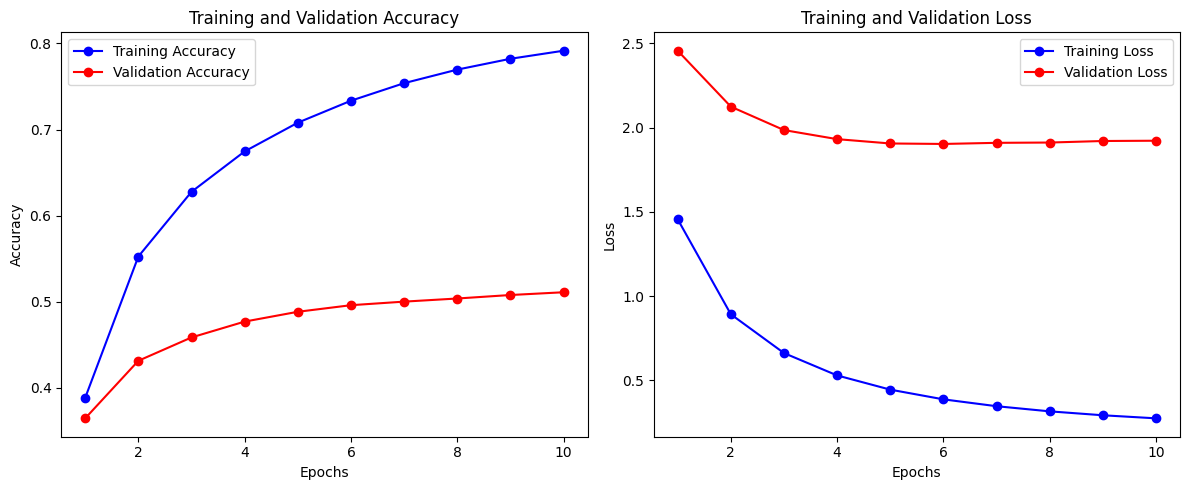

In [22]:
plot_training_history(history)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Early Stopping ---
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Reduce Learning Rate on Plateau ---
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Reduce learning rate by a factor of 0.5
    patience=3,       # Wait for 3 epochs before reducing
    verbose=1,
    min_lr=1e-6       # Do not go below this learning rate
)

In [26]:
from tensorflow.keras import backend as K

K.set_value(training_model.optimizer.lr, 0.0005) 

In [27]:
history = training_model.fit(
    train_dataset,
    validation_data=val_dataset,
    initial_epoch=10,
    epochs=200,  # Large number to let EarlyStopping decide when to stop
    callbacks=[
        checkpoint_cb_per_epoch,  # Save after every epoch
        checkpoint_cb_best,       # Save best model
        early_stopping_cb,        # Stop if no improvement
        reduce_lr_cb              # Reduce LR on plateau
    ]
)

Epoch 11/200
3487/3487 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.8135
Epoch 11: saving model to checkpoints/nmt_model_epoch_11.keras

Epoch 11: val_loss did not improve from 1.90260
3487/3487 [==============================] - 175s 50ms/step - loss: 0.2400 - accuracy: 0.8135 - val_loss: 1.9256 - val_accuracy: 0.5146 - lr: 5.0000e-04
Epoch 12/200
3487/3487 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.8207
Epoch 12: saving model to checkpoints/nmt_model_epoch_12.keras

Epoch 12: val_loss did not improve from 1.90260
3487/3487 [==============================] - 176s 50ms/step - loss: 0.2283 - accuracy: 0.8207 - val_loss: 1.9371 - val_accuracy: 0.5161 - lr: 5.0000e-04
Epoch 13/200
3486/3487 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.8258
Epoch 13: saving model to checkpoints/nmt_model_epoch_13.keras

Epoch 13: val_loss did not improve from 1.90260
3487/3487 [==============================] - 175s 50ms/ste

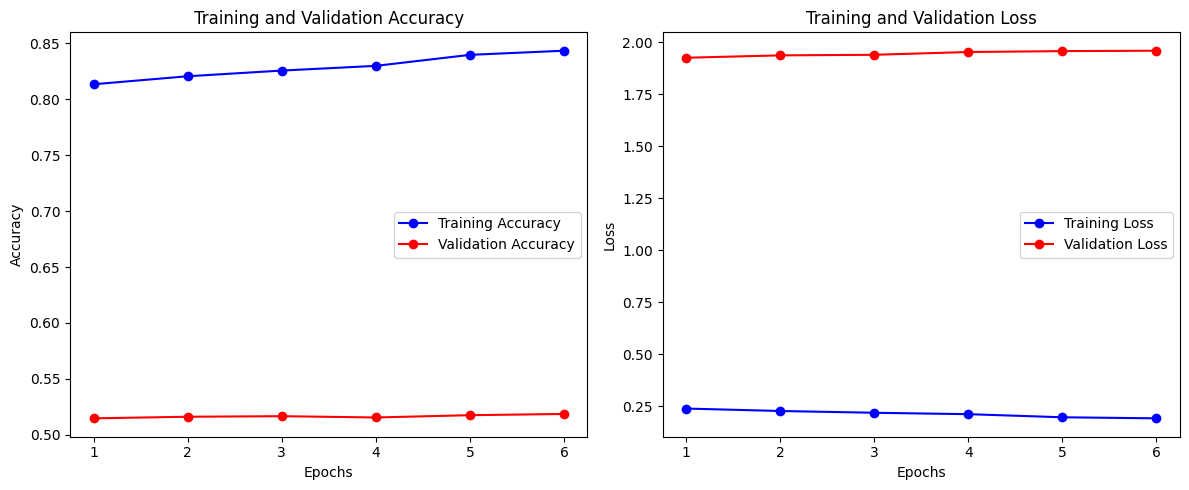

In [28]:
plot_training_history(history)

In [48]:
def predict_translation(input_sentence, encoder_inference_model, decoder_inference_model,
                        input_vocab, input_inv_vocab, target_vocab, target_inv_vocab,
                        Tx, Ty, beam_width=3, max_decoder_steps=None):
    """
    Translates a single English sentence to French using the trained NMT model
    with beam search.

    Args:
        input_sentence (str): The English sentence to translate.
        encoder_inference_model (tf.keras.Model): The trained encoder inference model.
        decoder_inference_model (tf.keras.Model): The trained decoder inference model.
        input_vocab (dict): English word_to_index vocabulary.
        input_inv_vocab (dict): English index_to_word vocabulary.
        target_vocab (dict): French word_to_index vocabulary.
        target_inv_vocab (dict): French index_to_word vocabulary.
        Tx (int): Max input sequence length used during training.
        Ty (int): Max target sequence length used during training (including EOS).
        beam_width (int): The width of the beam for beam search.
        max_decoder_steps (int, optional): Maximum steps for decoder. Defaults to Ty if None.

    Returns:
        str: The translated French sentence.
    """
    if max_decoder_steps is None:
        max_decoder_steps = Ty # Or adjust based on your desired max output length

    # 1. Preprocess the input sentence
    # Assuming `tokenize` is available globally or imported
    tokenized_input = tokenize([input_sentence])
    # Assuming `sentences_to_indices` is available globally or imported
    indexed_input = sentences_to_indices(tokenized_input, input_vocab)
    
    # Pad to Tx
    padded_input = tf.keras.preprocessing.sequence.pad_sequences(
        indexed_input, maxlen=Tx, padding='post', value=input_vocab["<pad>"]
    )
    padded_input = np.array(padded_input) # Ensure it's a numpy array for Keras

    # 2. Encode the input sentence
    # encoder_outputs: (1, Tx, lstm_units) - for attention
    # h, c: (1, lstm_units * 2) - initial decoder states
    encoder_outputs, h, c = encoder_inference_model.predict(padded_input, verbose=0)

    # 3. Initialize Beam Search
    # Each beam is a tuple: (sequence_of_indices, current_h_state, current_c_state, current_log_probability)
    # Start with <SOS> token. Log prob is 0 for initial state.
    beams = [([target_vocab["<sos>"]], h, c, 0.0)]
    final_translations = [] # To store completed translations (those that hit <EOS>)

    for _ in range(max_decoder_steps): # Iterate up to max output length
        all_candidates = []
        for seq, h_state, c_state, log_prob in beams:
            # If this beam has already produced an <EOS> token, keep it as is and add to final
            if seq[-1] == target_vocab["<eos>"]:
                final_translations.append((seq, log_prob))
                continue # Do not expand this beam further

            # Get the last generated token for the current beam
            last_token = seq[-1]
            
            # Prepare decoder input for one step (batch_size 1 for this single token)
            decoder_single_input = np.array([[last_token]]) 

            # Predict next token and states using the decoder inference model
            # decoder_outputs_probs: (1, 1, target_vocab_size)
            # new_h, new_c: (1, lstm_units * 2)
            decoder_outputs_probs, new_h, new_c = decoder_inference_model.predict(
                [decoder_single_input, encoder_outputs, h_state, c_state], verbose=0
            )

            # Get top 'beam_width' candidates from the probabilities
            # Flatten to (target_vocab_size,)
            token_probs = decoder_outputs_probs[0, 0, :] # Probabilities for the single predicted token
            
            # Get indices of top 'beam_width' probabilities
            # Use argsort to get indices, then slice the top `beam_width`
            # Add a small epsilon to probabilities to avoid log(0) for extremely low values
            # (though softmax output should prevent exact 0s, it's safer)
            top_k_indices = np.argsort(token_probs + 1e-10)[-beam_width:][::-1] # Sort descending

            for token_idx in top_k_indices:
                token_log_prob = np.log(token_probs[token_idx] + 1e-10) # Log probability of this token
                candidate_seq = seq + [token_idx] # Extend sequence
                candidate_log_prob = log_prob + token_log_prob # Accumulate log probability
                all_candidates.append((candidate_seq, new_h, new_c, candidate_log_prob))
        
        # Sort all expanded candidates (including those that hit EOS in previous step)
        # by their accumulated log probability and select top 'beam_width' for next iteration
        # Only consider active beams for expansion in the next loop.
        all_candidates.sort(key=lambda x: x[3], reverse=True)
        beams = all_candidates[:beam_width]

        # Check if all current beams have ended with <EOS>
        # If so, we can stop early, as no more expansion is needed for these paths.
        if all(b_seq[-1] == target_vocab["<eos>"] for b_seq, _, _, _ in beams):
            # Add remaining beams to final_translations if they ended with EOS
            final_translations.extend([(b_seq, b_log_prob) for b_seq, _, _, b_log_prob in beams if b_seq[-1] == target_vocab["<eos>"]])
            break # All active beams are done

    # After the loop, select the best translation from all completed and uncompleted beams
    # (uncompleted beams are those that reached max_decoder_steps without an EOS)
    if not final_translations and not beams:
        return "Translation failed: No valid sequences generated."
    
    # If no beams hit EOS, pick the best among the unfinished ones
    if not final_translations:
        best_seq, _, _, best_log_prob = max(beams, key=lambda x: x[3])
    else: # Otherwise, pick the best from the completed ones
        best_seq, best_log_prob = max(final_translations, key=lambda x: x[1])


    # Convert indices back to words, remove SOS/EOS/PAD tokens
    translated_words = []
    for idx in best_seq:
        if idx == target_vocab["<sos>"] or idx == target_vocab["<pad>"]:
            continue
        if idx == target_vocab["<eos>"]:
            break # Stop at EOS
        translated_words.append(target_inv_vocab.get(idx, '<unk>')) # Use .get with unk fallback

    return " ".join(translated_words)

In [49]:
eng_inv_vocab = {idx: word for word, idx in eng_vocab.items()}
fra_inv_vocab = {idx: word for word, idx in fra_vocab.items()}

In [51]:
sentences = [
    "How are you?",
    "I love machine learning.",
    "What time is it?",
    "Where is the nearest station?",
    "Thank you very much!"
]

for i, sen in enumerate(sentences, 1):
    translation = predict_translation(
        sen,
        encoder_inference_model,
        decoder_inference_model,
        eng_vocab,
        eng_inv_vocab,
        fra_vocab,
        fra_inv_vocab,
        Tx,
        Ty,
        beam_width=3  # or set >1 for beam search
    )
    
    print(f"{i}. English: {sen}")
    print(f"   French:  {translation}\n")

1. English: How are you?
   French:  comment vas-tu ?

2. English: I love machine learning.
   French:  j'adore les fraises

3. English: What time is it?
   French:  quelle heure est le temps ?

4. English: Where is the nearest station?
   French:  où se trouve la gare la plus proche ?

5. English: Thank you very much!
   French:  merci beaucoup !



In [52]:
sentences_to_translate = [
    "How are you?",
    "I love machine learning.",
    "What time is it?",
    "Where is the nearest station?",
    "Thank you very much!",
    "I want to go home.",
    "The weather is beautiful today.",
    "Can I help you?",
    "Please speak slowly.",
    "I don't understand.",
    "What is your name?",
    "My name is John.",
    "I am a student.",
    "He likes to read books.",
    "She plays the piano.",
    "We are learning French.",
    "They live in Paris.",
    "This is a difficult problem.",
    "I need some water.",
    "Do you speak English?",
    "Yes, a little.",
    "No, not at all.",
    "Good morning.",
    "Good night.",
    "See you later.",
    "Excuse me.",
    "I am sorry.",
    "It's a beautiful day.",
    "The cat is on the table.",
    "Where is the bathroom?",
    "I would like a coffee, please.",
    "How much does it cost?",
    "I am hungry.",
    "I am thirsty.",
    "Help me, please.",
    "Call an ambulance!",
    "I am lost.",
    "Can you show me the way?",
    "I live in Lahore.",
    "My favorite color is blue.",
    "This food is delicious.",
    "I enjoy traveling.",
    "What is your job?",
    "I am an engineer.",
    "It's raining outside.",
    "Happy birthday!",
    "I wish you good luck.",
    "The world is big.",
    "Tell me more.",
    "I need a break."
]

In [53]:
output_file_path = "translations_output.tsv"

In [54]:
with open(output_file_path, 'w', encoding='utf-8') as f_out:
    # Write header
    f_out.write("Original English\tFrench Prediction\n")

    print("\n--- Generating and Saving Translations ---")
    for i, sen in enumerate(sentences_to_translate, 1):
        translation = predict_translation(
            sen,
            encoder_inference_model,
            decoder_inference_model,
            eng_vocab,
            eng_inv_vocab,
            fra_vocab,
            fra_inv_vocab,
            Tx,
            Ty,
            beam_width=5 # Using a slightly higher beam_width for potentially better quality
        )

        print(f"{i}. English: {sen}")
        print(f"   French Prediction: {translation}")

        # Write to file (tab-separated)
        f_out.write(f"{sen}\t{translation}\n")

print(f"\nTranslations saved to: {output_file_path}")
print("\n--- Translation Process Complete ---")


--- Generating and Saving Translations ---
1. English: How are you?
   French Prediction: comment vas-tu ?
2. English: I love machine learning.
   French Prediction: j'adore les mathématiques.
3. English: What time is it?
   French Prediction: quelle heure est-il, ?
4. English: Where is the nearest station?
   French Prediction: où se trouve la gare la plus proche ?
5. English: Thank you very much!
   French Prediction: merci beaucoup !
6. English: I want to go home.
   French Prediction: je veux aller à la maison.
7. English: The weather is beautiful today.
   French Prediction: le temps est beau aujourd'hui.
8. English: Can I help you?
   French Prediction: puis-je vous aider ?
9. English: Please speak slowly.
   French Prediction: parle s'il te plaît.
10. English: I don't understand.
   French Prediction: je ne comprends pas.
11. English: What is your name?
   French Prediction: quel est votre nom de famille ?
12. English: My name is John.
   French Prediction: mon nom est mme jack

In [70]:
data_list = []

with open('translations_output.tsv', mode="r", encoding="utf-8") as file:
    # Read the header line and discard it
    header = file.readline()
    print(f"Skipping header: {header.strip()}")

    for line in file:
        stripped_line = line.strip()
        columns = stripped_line.split('\t')
        data_list.append(tuple(columns))

Skipping header: Original English	French Prediction


In [71]:
data_list

[('How are you?', 'comment vas-tu ?'),
 ('I love machine learning.', "j'adore les mathématiques."),
 ('What time is it?', 'quelle heure est-il, ?'),
 ('Where is the nearest station?', 'où se trouve la gare la plus proche ?'),
 ('Thank you very much!', 'merci beaucoup !'),
 ('I want to go home.', 'je veux aller à la maison.'),
 ('The weather is beautiful today.', "le temps est beau aujourd'hui."),
 ('Can I help you?', 'puis-je vous aider ?'),
 ('Please speak slowly.', "parle s'il te plaît."),
 ("I don't understand.", 'je ne comprends pas.'),
 ('What is your name?', 'quel est votre nom de famille ?'),
 ('My name is John.', 'mon nom est mme jackson.'),
 ('I am a student.', 'je suis étudiant.'),
 ('He likes to read books.', 'il aime lire des livres.'),
 ('She plays the piano.', 'elle joue du piano.'),
 ('We are learning French.', 'nous étudions le français.'),
 ('They live in Paris.', 'ils vivent à boston.'),
 ('This is a difficult problem.', "c'est un problème très difficile."),
 ('I need

In [86]:
list_of_translations_with_interpretations = [
    ('How are you?', 'comment vas-tu ?', 'how are you ?'),
    ('I love machine learning.', "j'adore les mathématiques.", 'i love mathematics.'),
    ('What time is it?', 'quelle heure est-il, ?', 'what time is it, ?'), # The extra comma is noted
    ('Where is the nearest station?', 'où se trouve la gare la plus proche ?', 'where is the nearest station ?'),
    ('Thank you very much!', 'merci beaucoup !', 'thank you very much !'),
    ('I want to go home.', 'je veux aller à la maison.', 'i want to go home.'),
    ('The weather is beautiful today.', "le temps est beau aujourd'hui.", 'the weather is beautiful today.'),
    ('Can I help you?', 'puis-je vous aider ?', 'can i help you ?'),
    ('Please speak slowly.', "parle s'il te plaît.", 'speak please.'), # Missing "slowly"
    ("I don't understand.", 'je ne comprends pas.', 'i do not understand.'),
    ('What is your name?', 'quel est votre nom de famille ?', 'what is your family name ?'), # More specific than "name"
    ('My name is John.', 'mon nom est mme jackson.', 'my name is mrs. jackson.'), # Hallucination on name
    ('I am a student.', 'je suis étudiant.', 'i am a student.'),
    ('He likes to read books.', 'il aime lire des livres.', 'he likes to read books.'),
    ('She plays the piano.', 'elle joue du piano.', 'she plays the piano.'),
    ('We are learning French.', 'nous étudions le français.', 'we are studying french.'), # 'étudions' is 'studying'
    ('They live in Paris.', 'ils vivent à boston.', 'they live in boston.'), # Hallucination on city
    ('This is a difficult problem.', "c'est un problème très difficile.", 'it is a very difficult problem.'),
    ('I need some water.', "j'ai besoin d'un peu d'eau.", 'i need some water.'),
    ('Do you speak English?', 'parles-tu déjà ?', 'do you speak already ?'), # Missing "English"
    ('Yes, a little.', 'un peu triste !', 'a little sad !'), # Hallucination
    ('No, not at all.', 'non, absolument pas du tout.', 'no, absolutely not at all.'),
    ('Good morning.', 'bon matin.', 'good morning.'), # Less common than "Bonjour" but understandable
    ('Good night.', 'bonne nuit !', 'good night !'),
    ('See you later.', 'à vous voir plus tard.', 'to see you later.'), # Formal "you" / plural "you"
    ('Excuse me.', 'excusez-moi.', 'excuse me.'),
    ('I am sorry.', 'je suis désolé.', 'i am sorry.'),
    ("It's a beautiful day.", "c'est une belle journée.", 'it is a beautiful day.'),
    ('The cat is on the table.', 'le chat est sur la table.', 'the cat is on the table.'),
    ('Where is the bathroom?', 'où sont les toilettes ?', 'where are the toilets ?'), # Common way to ask
    ('I would like a coffee, please.', "j'aimerais un café, s'il vous plaît.", 'i would like a coffee, please.'),
    ('How much does it cost?', 'combien coûte combien ?', 'how much does it cost how much ?'), # Redundant
    ('I am hungry.', "j'ai faim.", 'i am hungry.'),
    ('I am thirsty.', "j'ai soif.", 'i am thirsty.'),
    ('Help me, please.', "aide-moi, s'il te plait.", 'help me, please.'),
    ('Call an ambulance!', 'appelle un bisou !', 'call a kiss !'), # Hallucination
    ('I am lost.', 'je suis perdu.', 'i am lost.'),
    ('Can you show me the way?', "pouvez-vous m'indiquer le chemin ?", 'can you show me the way ?'),
    ('I live in Lahore.', 'je vis confortablement.', 'i live comfortably.'), # Hallucination on city
    ('My favorite color is blue.', 'ma couleur préférée est le bleu.', 'my favorite color is blue.'),
    ('This food is delicious.', 'cette nourriture est délicieux.', 'this food is delicious.'), # 'délicieuse' would be feminine
    ('I enjoy traveling.', "j'aime voyager.", 'i like to travel.'),
    ('What is your job?', 'quelle est votre travail ?', 'what is your work ?'), # "travail" = work
    ('I am an engineer.', 'je suis ingénieur.', 'i am an engineer.'),
    ("It's raining outside.", "il pleut à l'extérieur.", 'it is raining outside.'),
    ('Happy birthday!', 'bon anniversaire !', 'happy birthday !'),
    ('I wish you good luck.', 'je te souhaite bonne chance.', 'i wish you good luck.'),
    ('The world is big.', 'le monde est grand.', 'the world is big.'),
    ('Tell me more.', "dis-m'en davantage.", 'tell me more.'),
    ('I need a break.', "j'ai besoin d'une pause.", 'i need a break.'),
]

In [87]:
import csv

output_file = "translation_comparison.tsv"

header = ["Original English", "Model French Translation", "Back-Translated English"]

with open(output_file, mode="w", newline='', encoding="utf-8") as file:
    writer = csv.writer(file, delimiter="\t")
    writer.writerow(header)  # Write header
    for row in list_of_translations_with_interpretations:
        writer.writerow(row)

print(f"Saved to '{output_file}' successfully.")

Saved to 'translation_comparison.tsv' successfully.
